### Code for the paper "*A Deep Learning Algorithm Predicts Milk Yield and Production Stage of Dairy Cows utilizing Ultrasound Echotexture 3 Analysis of the Mammary Gland*"

It presents the model construction and the produced results for the “High Lactation – No Lactation” binary classification problem.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras import layers

Reading the file containing labeling info. The "name" column corresponds to an animal and the "dmy" column corresponds to the animal's milk yield.

In [2]:
df = pd.read_csv("milk_yield_labels.csv")

# Delete unnecessary column and rename the columns.
del df['Unnamed: 2'] 
df = df.rename(columns={'Cow': 'name', 'DMY':'dmy'})

print("Length of dataframe containing labeling info: ",len(df))
df.head()

Length of dataframe containing labeling info:  384


,name,dmy
0,2121_1,26.8
1,2137_1,31.2
2,2112_1,27.2
3,2144_1,23.1
4,2136_1,31.1


Reading the echotexture variable dataset. Each row contains the echotecture variables retrieved from the ultrasound images associated with the "name" variable.

In [3]:
df_features = pd.read_csv("echotexture_features.csv") #echotexture_features.csv
print ("Length of dataframe containing features: ",len(df_features))

# Deleting unnecessary column
del df_features['Unnamed: 0'] 
df_features.head()

Length of dataframe containing features:  2960


,name,Size_of_ROIs,Mean_Value,St._Deviation,Skewness,Excess,0.05_Quantil,0.95_Quantil,Gradient_Mean_value,Gradient_Variance,Percentage_non-zero_Gradients,Contrast,Correlation,Entropy,Homogenity,Run_Percentage,Long-run_Emphasis,Gray_Value_Distribution,Runlenght_Distribution
0,2034_13_A_1,20164,111.466624,99.899808,0.234842,-1.355725,0,254,137.803730,11913.340643,0.869272,52.668738,0.000100,3.829548,0.200230,0.500446,1.961451,3153.719651,4971.651273
1,2034_13_A_2,20726,108.776706,99.817442,0.304536,-1.316853,0,254,137.703334,11918.277062,0.867944,37.856220,0.000100,3.784306,0.203756,0.499807,1.979535,3250.616179,5058.993243
2,2034_13_B_1,19173,106.782454,99.605621,0.363742,-1.274954,0,254,140.308850,12117.035779,0.867939,52.409261,0.000101,3.752019,0.203282,0.500704,1.959375,3013.387917,4700.170833
3,2034_13_B_2,20592,108.368833,99.984585,0.311026,-1.325881,0,254,139.892161,12098.419467,0.868201,42.514924,0.000100,3.791516,0.202819,0.498980,1.976448,3220.705304,5044.439416
4,2034_13_C_1,19653,110.665344,100.427442,0.249584,-1.377616,0,254,138.174441,11933.870832,0.869333,51.104456,0.000099,3.830934,0.202701,0.498957,1.971446,3071.348562,4784.884153


#### Seven echotecture variables are selected and they are concatenated into a new vector of 56 elements (8 photos * 7 variables for each new sample).

In [4]:
selected_variable = 'Gradient_Mean_value'
selected_variable2 = 'Homogenity'
selected_variable3 = 'Correlation'
selected_variable4 = 'Percentage_non-zero_Gradients'
selected_variable5 = 'St._Deviation'
selected_variable6 = 'Gradient_Variance'
selected_variable7 = 'Entropy'

features = []
counter = 1
element = []
for index, row in df_features.iterrows():
    if counter % 8 == 0:
        name = row['name'][:-4]
        dmy = df.loc[df['name'] == name]['dmy'].values
        element.append(row[selected_variable])
        element.append(row[selected_variable2])
        element.append(row[selected_variable3])
        element.append(row[selected_variable4])
        element.append(row[selected_variable5])
        element.append(row[selected_variable6])
        element.append(row[selected_variable7])
        element.append(dmy[0])
        element.append(name)
        features.append(element)
        element = []
    else:
        element.append(row[selected_variable])
        element.append(row[selected_variable2])
        element.append(row[selected_variable3])
        element.append(row[selected_variable4])
        element.append(row[selected_variable5])
        element.append(row[selected_variable6])
        element.append(row[selected_variable7])
    counter += 1

# Creating a new dataframe of 56 elements extracted from echotecture variables + 'dmy', 'name'
col = ['A1','xA1','cA1','vA1','bA1','nA1','mA1', 'A2','xA2',\
       'cA2','vA2','bA2','nA2','mA2', 'B1', 'xB1','cB1','vB1','bB1','nB1','mB1', \
        'B2','xB2','cB2','vB2','bB2','nB2','mB2',\
       'C1','xC1','cC1','vC1','bC1','nC1','mC1',\
       'C2','xC2','cC2','vC2','bC2','nC2','mC2', \
        'D1','xD1','cD1','vD1','bD1','nD1','mD1',\
       'D2','xD2','cD2','vD2','bD2','nD2','mD2','dmy','name']

df2 = pd.DataFrame(features,columns = col)
print("length of dataframe: ",len(df2))
print(df2.tail(5))

length of dataframe:  370
             A1       xA1       cA1       vA1        bA1           nA1  \
365  135.425474  0.202683  0.000101  0.868294  99.281745  11901.791118   
366  134.004899  0.203152  0.000101  0.868317  99.582672  11963.869876   
367  134.992778  0.202277  0.000100  0.868629  99.722616  11895.902234   
368  136.768464  0.204036  0.000101  0.868243  99.597098  11976.791325   
369  135.736027  0.203498  0.000101  0.869119  99.284208  11887.479240   

          mA1          A2       xA2       cA2  ...       mD1          D2  \
365  3.750551  135.468471  0.202734  0.000101  ...  3.688899  136.916793   
366  3.787019  134.134725  0.203516  0.000101  ...  3.707755  135.913483   
367  3.816579  135.088029  0.203429  0.000101  ...  3.671907  136.097414   
368  3.773866  136.562914  0.202071  0.000101  ...  3.763866  139.411495   
369  3.753509  135.526978  0.203840  0.000101  ...  3.718130  138.275239   

          xD2       cD2       vD2        bD2           nD2       mD2   d

Some more data cleansing.

In [5]:
#Remove elements with ''-'' appearing in some values of the dmy.
df2.drop(df2[df2['dmy'] == '-'].index, inplace = True)
df2['dmy'] = df2['dmy'].astype(float)
print("Length of dataframe after dropping rows: ",len(df2))

Length of dataframe after dropping rows:  367


Label creation by grouping together features with daily milk yield lower than 10 for the No-Lactation class and greater than 45 for the High-Lactation class.

In [6]:
labels = []
for _,row in df2.iterrows():
    if row['dmy'] >= 0 and row['dmy'] <= 10:
        labels.append(0)
    elif row['dmy'] <= 1000 and row['dmy'] > 45:
        labels.append(1)
    else:
        # All the other cases are of no interest
        labels.append(-1)
        
df2['labels'] = labels
print("Length of dataframe: ", len(df2))

# Drop rows with label value -1
index_names = df2[ df2['labels'] == -1 ].index
df2.drop(index_names , inplace=True)

print("New length of dataframe after dropping classes between No and High Lactation: ", len(df2))
df2.head()

Length of dataframe:  367
New length of dataframe after dropping classes between No and High Lactation:  181


,A1,xA1,cA1,vA1,bA1,nA1,mA1,A2,xA2,cA2,...,D2,xD2,cD2,vD2,bD2,nD2,mD2,dmy,name,labels
0,137.803730,0.200230,0.000100,0.869272,99.899808,11913.340643,3.829548,137.703334,0.203756,0.000100,...,140.668993,0.203500,0.000100,0.868393,100.024194,12133.372958,3.749032,48.8,2034_13,1
1,138.370130,0.203091,0.000099,0.868500,100.239572,11952.724369,3.752849,138.308072,0.202453,0.000100,...,140.714128,0.202871,0.000099,0.868433,100.226555,12115.368664,3.740860,54.2,2034_14,1
2,136.770323,0.202598,0.000100,0.868316,99.769798,11940.014039,3.783610,136.873462,0.202613,0.000101,...,140.720533,0.203046,0.000099,0.867478,100.220047,12076.644927,3.702795,54.3,2034_15,1
3,138.022112,0.203373,0.000099,0.868499,100.181162,11956.153750,3.788272,137.800879,0.202201,0.000100,...,138.821787,0.203337,0.000101,0.868267,99.564395,12019.929259,3.725226,54.3,2034_16,1
4,136.819332,0.203565,0.000101,0.868417,99.427896,11900.746270,3.740921,136.688392,0.203005,0.000101,...,141.182608,0.203151,0.000099,0.867453,100.215065,12119.984793,3.698982,52.4,2034_17,1


### Model creation - Classes selection - Training - Validation - Testing

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2850      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Train on 135 samples, validate on 23 samples
Epoch 1/50
135/135 [==============================] - 1s 7ms/sample - loss: 0.6783 - accuracy: 0.5630 - val_loss: 0.6365 - val_accuracy: 0.6522
Epoch 2/50
135/135 [==============================] - 0s 296us/

135/135 [==============================] - 0s 355us/sample - loss: 0.3809 - accuracy: 0.8222 - val_loss: 0.3593 - val_accuracy: 0.8696
-----Validation set------
Validation Accuracy:  0.8695652
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.83      0.91      0.87        11

    accuracy                           0.87        23
   macro avg       0.87      0.87      0.87        23
weighted avg       0.87      0.87      0.87        23

-----Unseen test set predictions------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.91      0.91      0.91        11

    accuracy                           0.91        23
   macro avg       0.91      0.91      0.91        23
weighted avg       0.91      0.91      0.91        23

Confusion Matrix of unseen test set: 
 [[11  1]
 [ 1 10]]


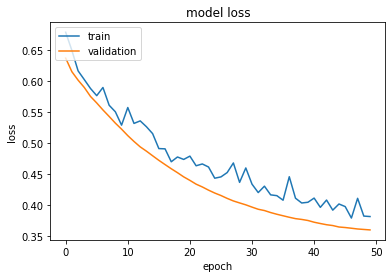

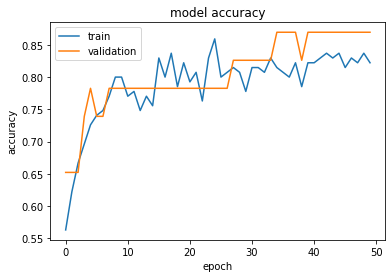

In [7]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(56, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
model.compile(
 optimizer = 'sgd',
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

all_features = ['A1','xA1','cA1','vA1','bA1','nA1','mA1', 'A2','xA2',\
       'cA2','vA2','bA2','nA2','mA2', 'B1', 'xB1','cB1','vB1','bB1','nB1','mB1', \
        'B2','xB2','cB2','vB2','bB2','nB2','mB2',\
       'C1','xC1','cC1','vC1','bC1','nC1','mC1',\
       'C2','xC2','cC2','vC2','bC2','nC2','mC2', \
        'D1','xD1','cD1','vD1','bD1','nD1','mD1',\
       'D2','xD2','cD2','vD2','bD2','nD2','mD2']

X = df2[all_features].values.tolist()
Y = df2[['labels']].values.tolist()
X = np.array(X)
Y = [y[0] for y in Y]

# Splitting to training, validation and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,stratify=Y)
X_test, final_x_test, y_test, final_y_test = train_test_split(X_test, y_test, test_size=0.5,stratify=y_test)

# Data transformation and normalization
y_train = np.array(y_train)
y_test = np.array(y_test)
final_y_test= np.array(final_y_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_TR = scaler.transform(X_train)
X_test_TR = scaler.transform(X_test)
final_x_test_TR = scaler.transform(final_x_test)

#Train the model
epochs = 50
batch_size = 14
results = model.fit(
    X_train_TR, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_TR, y_test)
)

# Validation set
print("-----Validation set------")
print("Validation Accuracy: ", results.history["val_accuracy"][-1])

pred = model.predict(X_test_TR)
rounded = []
for p in pred:
    rounded.append(np.round(p))

print(classification_report(y_test, rounded))

# Test set
print("-----Unseen test set predictions------")
pred = model.predict(final_x_test_TR)
rounded = []
for p in pred:
    rounded.append(np.round(p))

print(classification_report(final_y_test, rounded))
print("Confusion Matrix of unseen test set: \n", confusion_matrix(final_y_test, rounded))

model_name = 'milk_yield'+"_ep_"+str(epochs)+"_bss_"+str(batch_size) 

# "Loss"
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_valloss_'+model_name+'.png', dpi=600)
plt.show()

#  "Accuracy"
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_vallacc_'+model_name+'.png', dpi=600)
plt.show()

Plotting the ROC curve.

In [9]:
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score

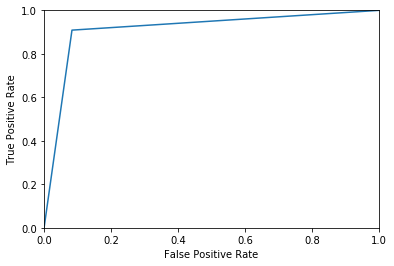

In [8]:
def plot_roc_curve(fpr,tpr,model_name): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
     
    plt.savefig('roc_curve'+model_name+'.png', dpi=600)
    plt.show() 
    
fpr , tpr , thresholds = roc_curve( final_y_test, rounded)#y_unseen_stacked , predictions)
plot_roc_curve (fpr,tpr,model_name) 